In [106]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import convolve

In [107]:
file_path = "data\\assignmentSegmentBrainGmmEmMrf.mat"
with h5py.File(file_path, 'r') as mat_file:
    for key in mat_file.keys():
        print(f"Dataset: {key}, Shape: {mat_file[key].shape}")


Dataset: imageData, Shape: (256, 256)
Dataset: imageMask, Shape: (256, 256)


In [108]:
with h5py.File(file_path, 'r') as mat_file:
    data = np.array(mat_file['imageData'])
    mask = np.array(mat_file['imageMask'])

Text(0.5, 1.0, 'imageMask')

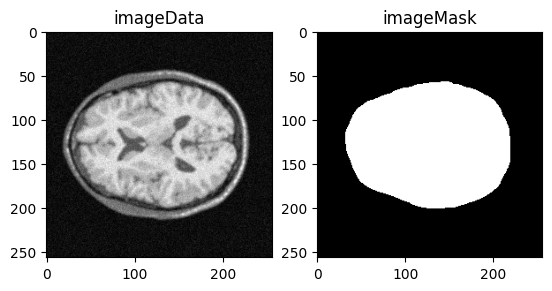

In [109]:
plt.subplot(1, 2, 1)
plt.imshow(data, cmap='gray')
plt.title('imageData')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('imageMask')

(256, 256)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


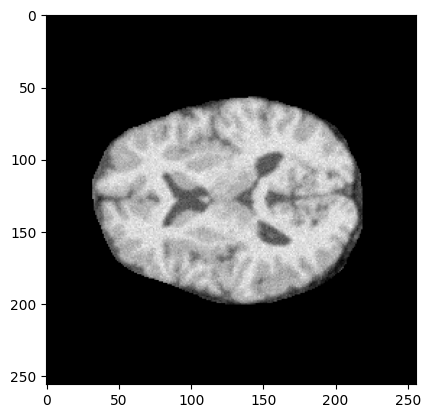

In [110]:
# Multiplying each pixel with the mask to remove the part outside the mask
brainData = data * mask
print(brainData.shape)
plt.imshow(brainData, cmap='gray')
print(brainData)

In [111]:
beta=0.5
max_iter=30
tol=1e-4

data = data
Y = brainData.astype(np.float64)
mask = mask.astype(np.bool_)

# Normalize image intensity to [0,1]
Y = Y / np.max(Y)

# Number of classes
K = 3

print("Chosen value for β:", beta)

Chosen value for β: 0.5


Initial label image (x) obtained using intensity quantiles:
Pixels below the 33rd percentile are labeled 0, between 33rd and 67th as 1, and above 67th as 2.


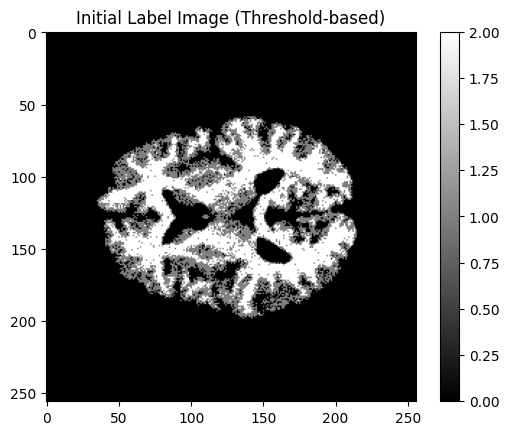

In [112]:
# Initializing label image
Y_brain = Y[mask]

# Using 1/3 and 2/3 values for thresholding
p33, p67 = np.percentile(Y_brain, [33, 67])

# Initial label image x: 
#    label 0 if intensity < p33,
#    label 1 if intensity is between p33 and p67,
#    label 2 if intensity > p67.
labels = np.zeros_like(Y)
labels[mask] = np.where(Y_brain < p33, 0, np.where(Y_brain < p67, 1, 2))

print("Initial label image (x) obtained using intensity quantiles:")
print("Pixels below the 33rd percentile are labeled 0, between 33rd and 67th as 1, and above 67th as 2.")
plt.figure()
plt.imshow(labels, cmap='gray')
plt.title("Initial Label Image (Threshold-based)")
plt.colorbar()
plt.show()

In [113]:
# Initializing Gaussian Parameters
class_means = np.zeros(K)
class_stds = np.zeros(K)

n_brain_pixels = np.sum(mask)
memberships = np.zeros((n_brain_pixels, K))
for k in range(K):
    pixels_k = Y_brain[labels[mask] == k]
    class_means[k] = np.mean(pixels_k)
    class_stds[k] = np.std(pixels_k) + 1e-10  # add epsilon to avoid zero std
    memberships[labels[mask] == k, k] = 1.0  # hard assignment

print("Initial Gaussian parameters (based on thresholded labels):")
print("Class means:", class_means)
print("Class standard deviations:", class_stds)

Initial Gaussian parameters (based on thresholded labels):
Class means: [0.48491153 0.7252722  0.84963664]
Class standard deviations: [0.14863408 0.03417388 0.03891516]


In [114]:
def gaussian_likelihood(Y_vals, mu, sigma):
    return 1.0 / (np.sqrt(2*np.pi) * sigma) * np.exp(-0.5 * ((Y_vals - mu) / sigma)**2)

In [115]:
def gaussian_log_likelihood(y, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((y - mu)**2) / (sigma**2)

In [116]:
def compute_mrf_prior(label_img, beta, mask):
    mrf_energy = 0.0
    for shift in [(0,1), (1,0), (0,-1), (-1,0)]:
        diff = label_img != np.roll(label_img, shift, axis=(0, 1))
        mrf_energy += np.sum(diff * mask)  # only count pixels inside the brain
    return -beta * mrf_energy

In [117]:
def global_log_posterior(labels, Y, mask, class_means, class_stds, beta):
    indices = np.where(mask)
    logL = 0.0
    for i, j in zip(indices[0], indices[1]):
        # Ensure that the label is converted to a Python integer.
        k = int(labels[i, j])
        y_val = Y[i, j]
        logL += gaussian_log_likelihood(y_val, class_means[k], class_stds[k])
    return logL + compute_mrf_prior(labels, beta, mask)


In [118]:
def compute_local_log_posterior(i, j, Y, labels, class_means, class_stds, beta, mask):

    K = len(class_means)
    posteriors = np.zeros(K)
    y_val = Y[i, j]
    for k in range(K):
        ll = gaussian_log_likelihood(y_val, class_means[k], class_stds[k])
        neighbor_count = 0
        for di, dj in [(0,1), (1,0), (0,-1), (-1,0)]:
            ni, nj = i + di, j + dj
            if 0 <= ni < Y.shape[0] and 0 <= nj < Y.shape[1] and mask[ni, nj]:
                neighbor_count += 1 if labels[ni, nj] == k else 0
        posteriors[k] = ll + beta * neighbor_count
    return posteriors


In [ ]:
indices = np.where(mask)  
n_pixels = len(Y_brain)   
log_posteriors_history = []

for iter in range(max_iter):
    memberships_old = memberships.copy()
    labels_old = labels.copy()
    
    # Updating Membership Values (E-step)
    likelihood = np.zeros((n_pixels, K))
    for k in range(K):
        likelihood[:, k] = gaussian_likelihood(Y_brain, class_means[k], class_stds[k])
    
    # Compute MRF prior factor for each class using a 4-neighborhood count.
    full_prior = np.zeros((Y.shape[0], Y.shape[1], K))
    kernel_4 = np.array([[0, 1, 0],
                            [1, 0, 1],
                            [0, 1, 0]])
    for k in range(K):
        label_k = (labels == k).astype(np.float64)
        count_neighbors = convolve(label_k, kernel_4, mode='reflect')
        full_prior[:, :, k] = np.exp(beta * count_neighbors)
    prior_factor = np.zeros((n_pixels, K))
    for idx, (i, j) in enumerate(zip(indices[0], indices[1])):
        for k in range(K):
            prior_factor[idx, k] = full_prior[i, j, k]
    
    membership_numerators = likelihood * prior_factor
    membership_denoms = np.sum(membership_numerators, axis=1, keepdims=True) + 1e-10
    memberships = membership_numerators / membership_denoms
    
    # Updating Gaussian Parameters (M-step)
    for k in range(K):
        weights = memberships[:, k]
        class_means[k] = np.sum(weights * Y_brain) / (np.sum(weights) + 1e-10)
        class_stds[k] = np.sqrt(np.sum(weights * (Y_brain - class_means[k])**2) / (np.sum(weights) + 1e-10))
    
    # ICM Update for Labeling
    candidate_labels = np.copy(labels)
    for idx, (i, j) in enumerate(zip(indices[0], indices[1])):
        local_log_post = compute_local_log_posterior(i, j, Y, labels, class_means, class_stds, beta, mask)
        candidate_labels[i, j] = np.argmax(local_log_post)
    
    old_global = global_log_posterior(labels, Y, mask, class_means, class_stds, beta)
    candidate_global = global_log_posterior(candidate_labels, Y, mask, class_means, class_stds, beta)
    # update labels only if global log-posterior increases
    if candidate_global >= old_global:
        new_labels = candidate_labels.copy()
    else:
        new_labels = labels.copy()  # Reject update if global log-posterior decreases.
    
    log_posteriors_history.append((old_global, global_log_posterior(new_labels, Y, mask, class_means, class_stds, beta)))
    print(f"Iteration {iter+1} - Global log-posterior before ICM: {old_global:.1f}, after ICM: {global_log_posterior(new_labels, Y, mask, class_means, class_stds, beta):.1f}")
    
    labels = new_labels.copy()
    
    # Convergence check: if memberships change very little, break.
    if np.linalg.norm(memberships - memberships_old) < tol:
        print("EM convergence reached at iteration", iter+1)
        break


Iteration 1 - Global log-posterior before ICM: 19138.9, after ICM: 23042.0
Iteration 2 - Global log-posterior before ICM: 23148.7, after ICM: 23872.1
Iteration 3 - Global log-posterior before ICM: 23938.9, after ICM: 24321.1
Iteration 4 - Global log-posterior before ICM: 24361.5, after ICM: 24545.4
Iteration 5 - Global log-posterior before ICM: 24565.4, after ICM: 24711.1
Iteration 6 - Global log-posterior before ICM: 24723.4, after ICM: 24770.6
Iteration 7 - Global log-posterior before ICM: 24775.5, after ICM: 24837.2
Iteration 8 - Global log-posterior before ICM: 24840.0, after ICM: 24877.6
Iteration 9 - Global log-posterior before ICM: 24879.1, after ICM: 24927.2
Iteration 10 - Global log-posterior before ICM: 24928.3, after ICM: 24930.0
Iteration 11 - Global log-posterior before ICM: 24929.9, after ICM: 24933.7
Iteration 12 - Global log-posterior before ICM: 24933.7, after ICM: 24936.7
Iteration 13 - Global log-posterior before ICM: 24936.5, after ICM: 24944.8
Iteration 14 - Global

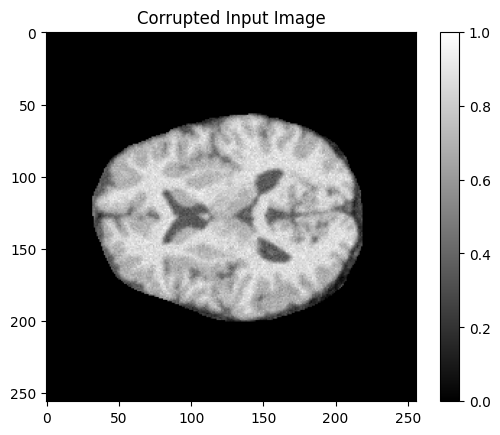

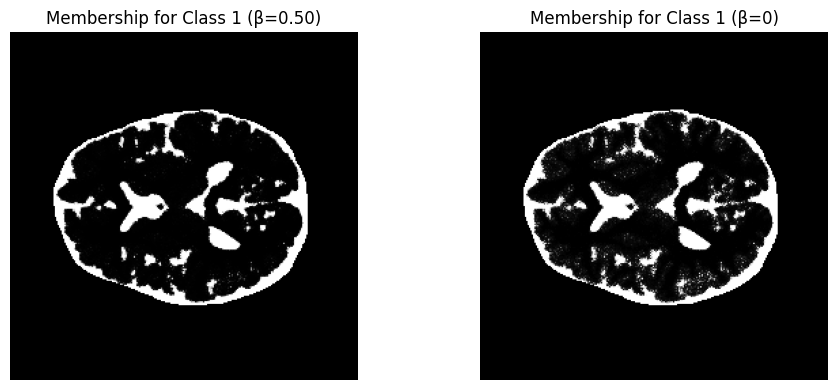

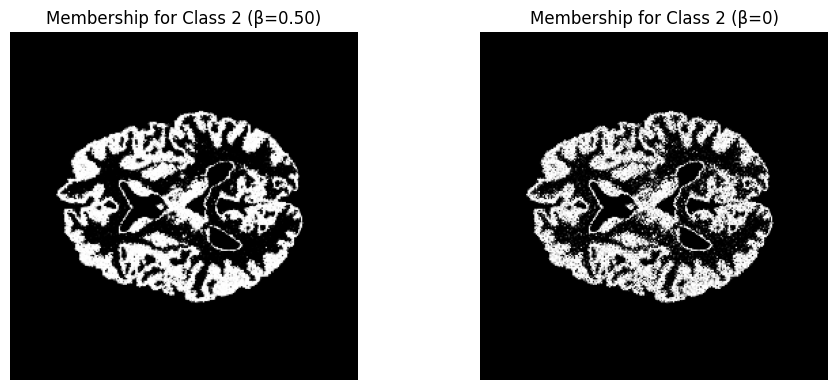

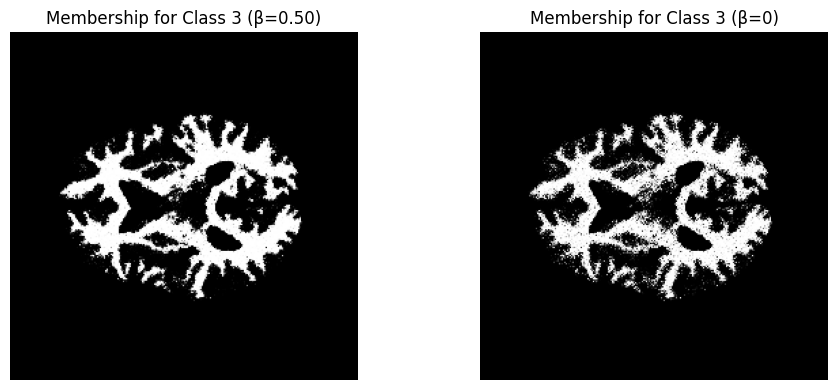

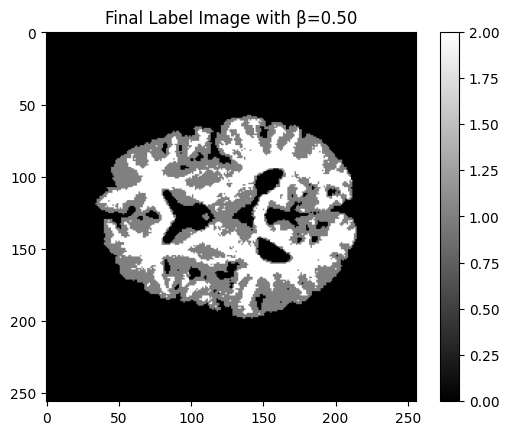

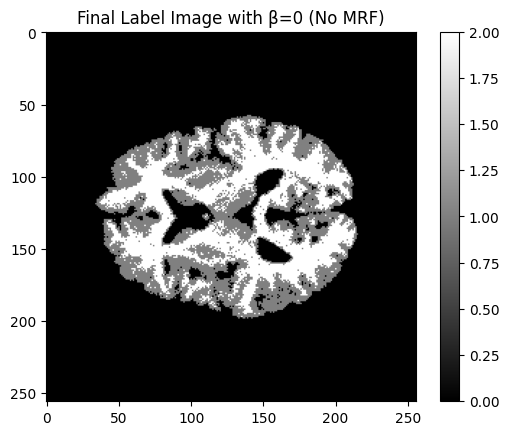

Optimal class means for chosen β: [0.41948083 0.69905203 0.84110919]


In [ ]:
# Display the corrupted input image.
plt.figure()
plt.imshow(Y, cmap='gray')
plt.title("Corrupted Input Image")
plt.colorbar()
plt.show()

# For each class, display side-by-side membership images (with MRF and with β=0).
likelihood_noMRF = np.zeros((n_pixels, K))
for k in range(K):
    likelihood_noMRF[:, k] = gaussian_likelihood(Y_brain, class_means[k], class_stds[k])
memberships_noMRF = likelihood_noMRF / (np.sum(likelihood_noMRF, axis=1, keepdims=True) + 1e-10)

for k in range(K):
    mem_img_mrf = np.zeros_like(Y)
    mem_img_noMRF = np.zeros_like(Y)
    mem_img_mrf[mask] = memberships[:, k]
    mem_img_noMRF[mask] = memberships_noMRF[:, k]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(mem_img_mrf, cmap='gray')
    axes[0].set_title(f"Membership for Class {k+1} (β={beta:.2f})")
    axes[0].axis('off')
    axes[1].imshow(mem_img_noMRF, cmap='gray')
    axes[1].set_title(f"Membership for Class {k+1} (β=0)")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

# Final label image with MRF
plt.imshow(labels, cmap='gray')
plt.title(f"Final Label Image with β={beta:.2f}")
plt.colorbar()
plt.show()

# Final label image for β = 0 (no MRF)
labels_noMRF = np.zeros_like(Y)
labels_noMRF[mask] = np.argmax(likelihood_noMRF, axis=1)
plt.figure()
plt.imshow(labels_noMRF, cmap='gray')
plt.title("Final Label Image with β=0 (No MRF)")
plt.colorbar()
plt.show()

# Print the optimal class means
print("Optimal class means for chosen β:", class_means)
